## Analyse Future Populations

Despite outliers being removed from the validation and holdout set, initial analysis with fitted models indicated strange populations of fruit.

The purpose of this notebook is to document these populations, flag them and remove them from future comparisons.

## Setup

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from utils import peval

In [78]:
dfs = {
    "model_1": pd.read_pickle("data/predictions/model_1.pkl"),
    "model_2": pd.read_pickle("data/predictions/model_2.pkl"),
    "model_3": pd.read_pickle("data/predictions/model_3.pkl"),
}
dfs["combined"] = pd.concat(dfs.values(), keys=dfs.keys(), names=["model", "original_index"])
dfs["combined"].reset_index(level="model", inplace=True)
dfs["combined"].reset_index(inplace=True)

dfs["combined"]

,original_index,model,partition,train_partition,subsequent_flag_1,sample_order_1,partition_ext,origin,population,date,...,region,cultivar,physio_stage,temp,reference_no,dry_matter,instrument,spectra_no,y_true,y_pred
0,36408,model_1,train,calibration,0,0,,nich,105600,2017-10-09,...,NT,1201,green,undef,3391,18.060310,15016,37690,18.060310,18.625060
1,45878,model_1,train,calibration,0,1,,nich,107201,2017-10-27,...,NT,caly,green,undef,4076,15.135730,15038,46920,15.135730,15.864243
2,44252,model_1,train,calibration,0,3,,nich,106900,2017-10-23,...,NT,kp,green,undef,3943,22.901620,15029,45604,22.901620,20.577597
3,24234,model_1,train,calibration,0,4,,nich,103109,2016-10-14,...,NT,r2e2,ripen,mid,1988,13.186000,15015,25544,13.186000,13.849288
4,22556,model_1,train,calibration,0,6,,nich,103105,2016-10-13,...,NT,caly,ripen,low,1824,18.594000,15023,23782,18.594000,17.694735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234472,71902,model_3,validation,calibration,0,85396,,nich,112500,2019-03-04,...,QLD,caly,ripen,undef,7550,13.774184,18029,77108,13.774184,14.227664
234473,6947,model_3,train,calibration,0,85397,,nich,100600,2015-10-23,...,NT,kp,green,mid,214,12.187465,15029,6439,12.187465,14.446321
234474,48401,model_3,train,calibration,0,85398,,nich,107400,2017-11-17,...,QLD,hg,green,undef,4325,13.775450,15038,49711,13.775450,15.271643
234475,59457,model_3,validation,tunning,0,85399,,nich,109900,2018-08-07,...,NT,caly,ripen,undef,5425,15.969130,15027,60783,15.969130,16.104063


In [79]:
dfs["combined"].groupby(["subsequent_flag_1"]).size()

subsequent_flag_1
0    213015
1      5790
2      8160
3      1080
4       720
5      1275
6      4437
dtype: int64

## Analysis

In [80]:
dfs["model_1"].groupby("population").size()

population
100100     480
100200    1040
100300    1520
100400    1440
100500    1200
          ... 
200400     196
200500     220
200600     200
200700     160
200800      70
Length: 183, dtype: int64

In [81]:
# compute scores for every population
data = dfs["combined"]
metrics = (
    data
    .groupby(["model", "season", "population"])
    .apply(lambda x: 
        {
            "instruments": x["instrument"].nunique(),
            **peval.calculate_metrics(y_true=x["y_true"], y_pred=x["y_pred"], plot=False),
            
        }
    )
    .apply(pd.Series)
    .reset_index()
)
# combined_metrics = metrics.set_index(["model", "season", "population", "n"]).unstack(level=0)
pop_metrics = metrics[["model", "season", "population", "instruments", "n", "rmse", "sep", "bias"]].set_index(["model", "season", "population", "instruments", "n"]).unstack(level=0)
pop_metrics.columns = ["_".join(col).strip() for col in pop_metrics.columns.values]
pop_metrics["rmse_mean"] = (pop_metrics["rmse_model_1"] + pop_metrics["rmse_model_2"] + pop_metrics["rmse_model_3"])/3
pop_metrics["sep_mean"] = (pop_metrics["sep_model_1"] + pop_metrics["sep_model_2"] + pop_metrics["sep_model_3"])/3
pop_metrics["bias_mean"] = (pop_metrics["bias_model_1"] + pop_metrics["bias_model_2"] + pop_metrics["bias_model_3"])/3
pop_metrics.reset_index(inplace=True)
pop_metrics.sort_values(by="rmse_mean", ascending=False, inplace=True)
pop_metrics

,season,population,instruments,n,rmse_model_1,rmse_model_2,rmse_model_3,sep_model_1,sep_model_2,sep_model_3,bias_model_1,bias_model_2,bias_model_3,rmse_mean,sep_mean,bias_mean
164,2020,114500,1.0,80.0,2.876652,3.402944,3.660799,0.507650,0.563256,0.596598,-2.832073,-3.356596,-3.612474,3.313465,0.555835,-3.267048
146,2019,112800,9.0,1440.0,2.851415,2.295841,2.781043,1.751221,0.981135,1.524776,2.250760,2.075797,2.326128,2.642766,1.419044,2.217561
180,2021,122300,1.0,80.0,2.265613,2.604077,2.925429,0.535577,0.552503,0.503188,-2.202213,-2.545540,-2.882378,2.598373,0.530423,-2.543377
162,2020,114300,2.0,80.0,3.172984,1.713825,1.991804,2.815234,1.215490,1.405233,1.497115,1.215832,1.420313,2.292871,1.811986,1.377753
147,2019,112900,8.0,1280.0,2.493547,1.732732,2.519570,1.815805,1.061079,1.670926,1.709738,1.370165,1.886377,2.248616,1.515937,1.655427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,2016,103108,4.0,239.0,0.635817,0.545094,0.532414,0.612589,0.537145,0.463540,0.174838,0.099045,0.263619,0.571108,0.537758,0.179167
142,2018,200100,1.0,190.0,0.671126,0.507975,0.533843,0.491155,0.477881,0.479925,-0.458745,0.175698,0.236374,0.570981,0.482987,-0.015557
128,2018,110803,1.0,80.0,0.701507,0.515726,0.440421,0.483077,0.427811,0.430424,-0.511533,-0.291957,-0.104984,0.552551,0.447104,-0.302824
28,2016,102700,3.0,30.0,0.563272,0.585443,0.371565,0.537473,0.462193,0.376479,0.195006,0.369110,0.032375,0.506760,0.458715,0.198831


In [82]:
pop_metrics.query("(season >= 2018 and rmse_model_1 > 1.2 and rmse_model_2 > 1.2 and rmse_model_3 > 1.2)").merge(
    dfs["combined"][["population", "subsequent_flag_1"]].drop_duplicates()
)

,season,population,instruments,n,rmse_model_1,rmse_model_2,rmse_model_3,sep_model_1,sep_model_2,sep_model_3,bias_model_1,bias_model_2,bias_model_3,rmse_mean,sep_mean,bias_mean,subsequent_flag_1
0,2020,114500,1.0,80.0,2.876652,3.402944,3.660799,0.507650,0.563256,0.596598,-2.832073,-3.356596,-3.612474,3.313465,0.555835,-3.267048,6
1,2019,112800,9.0,1440.0,2.851415,2.295841,2.781043,1.751221,0.981135,1.524776,2.250760,2.075797,2.326128,2.642766,1.419044,2.217561,2
2,2021,122300,1.0,80.0,2.265613,2.604077,2.925429,0.535577,0.552503,0.503188,-2.202213,-2.545540,-2.882378,2.598373,0.530423,-2.543377,6
3,2020,114300,2.0,80.0,3.172984,1.713825,1.991804,2.815234,1.215490,1.405233,1.497115,1.215832,1.420313,2.292871,1.811986,1.377753,3
4,2019,112900,8.0,1280.0,2.493547,1.732732,2.519570,1.815805,1.061079,1.670926,1.709738,1.370165,1.886377,2.248616,1.515937,1.655427,2
5,2018,110900,3.0,240.0,2.519603,2.379295,1.786608,0.804494,0.599670,0.712257,2.388281,2.302811,1.639138,2.228502,0.705474,2.110077,4
6,2020,114600,1.0,80.0,1.493202,2.366580,2.566781,0.641867,0.756971,0.688503,-1.350114,-2.243849,-2.473915,2.142188,0.695780,-2.022626,6
7,2020,114100,9.0,920.0,2.338719,1.726568,1.847311,2.063941,1.499077,1.557242,1.101990,0.858048,0.995083,1.970866,1.706754,0.985041,0
8,2020,114100,9.0,920.0,2.338719,1.726568,1.847311,2.063941,1.499077,1.557242,1.101990,0.858048,0.995083,1.970866,1.706754,0.985041,5
9,2020,114100,9.0,920.0,2.338719,1.726568,1.847311,2.063941,1.499077,1.557242,1.101990,0.858048,0.995083,1.970866,1.706754,0.985041,3


## Subsequently Flagged Pops

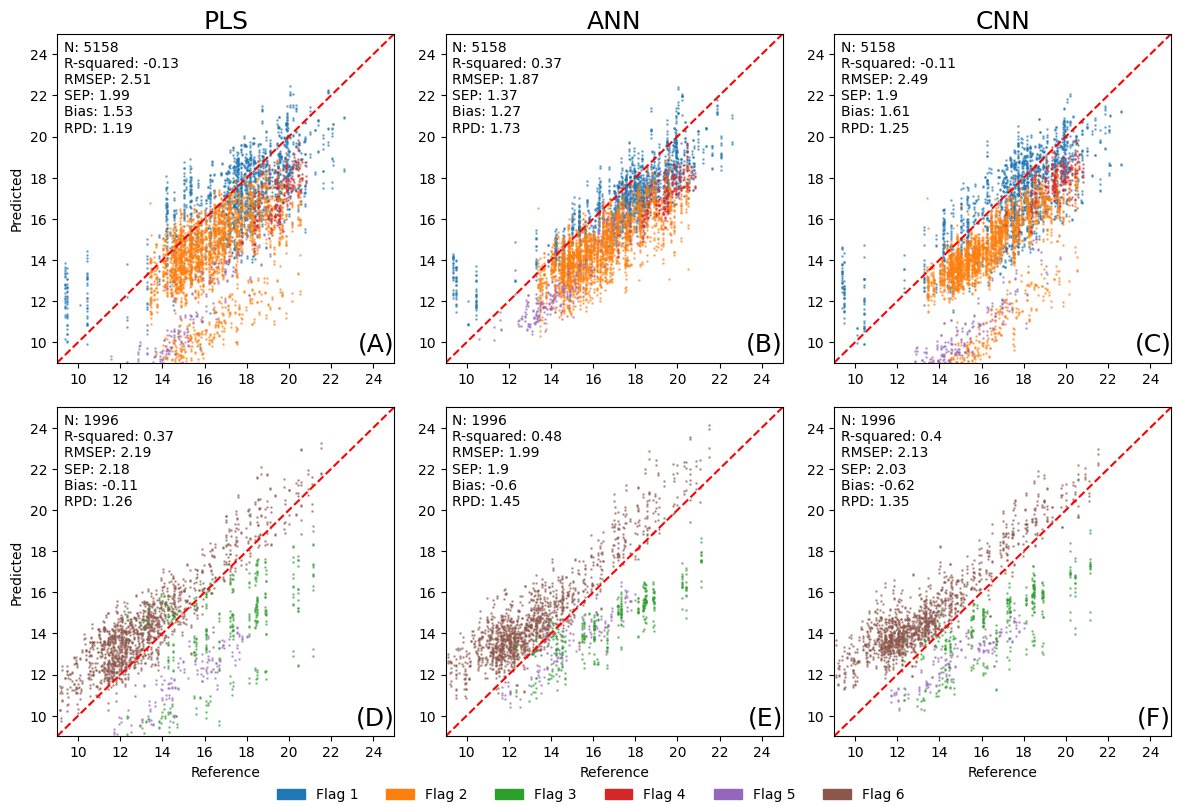

In [86]:
import seaborn as sns
import matplotlib.patches as mpatches

test_sets = {
    "validation": "subsequent_flag_1 != 0 and partition == 'validation'",
    "holdout": "subsequent_flag_1 != 0 and partition == 'holdout'",
}

# Generate a color palette
all_unique_flags = dfs["model_1"].query("subsequent_flag_1 != 0")["subsequent_flag_1"].unique()
palette = sns.color_palette("tab10", len(all_unique_flags))
all_unique_flags.sort()
flag_to_color = {flag: color for flag, color in zip(all_unique_flags, palette)}
legend_handles = [mpatches.Patch(color=flag_to_color[flag], label=f'Flag {flag}') for flag in all_unique_flags]


# create a figure with subplots - 4 rows (one for each query) and 3 columns (one for each model)
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('default')
fig, axes = plt.subplots(len(test_sets), 3, figsize=(12, 4*len(test_sets)))

# global min and max for axis scaling
global_min, global_max = 9, 25
test_sets


for i, (key, query) in enumerate(test_sets.items()):
    models = {
        "PLS": dfs["model_1"].query(query),
        "ANN": dfs["model_2"].query(query),
        "CNN": dfs["model_3"].query(query)
    }
    
    # calculate metrics for each model
    metrics = {}
    for model_name, data in models.items():
        metrics[model_name] = peval.calculate_metrics(y_true=data["y_true"], y_pred=data["y_pred"], plot=False)
    stats = {}
    for model_name, metric in metrics.items():
        stats[model_name] = f"N: {metric['n']}\nR-squared: {round(metric['r2'], 2)}\nRMSEP: {round(metric['rmse'], 2)}\nSEP: {round(metric['sep'], 2)}\nBias: {round(metric['bias'], 2)}\nRPD: {round(metric['rpd'], 2)}"
    
    # plotting
    for j, (model_name, data) in enumerate(models.items()):
        ax = axes[i, j] if len(test_sets) > 1 else axes[j]  # Handle indexing for axes
        
        # generate color mapping for populations
        unique_flag = data["subsequent_flag_1"].unique()
        for population in unique_flag:
            data_p = data[data["subsequent_flag_1"] == population]
            ax.scatter(data_p["y_true"], data_p["y_pred"], s=0.8, alpha=0.5, color=flag_to_color[population])
        ax.plot([global_min, global_max], [global_min, global_max], linestyle='--', color='red')
        
        if j in [0]: 
            ax.set_ylabel("Predicted")
            
        if i in [0]: 
            ax.set_title(model_name, fontsize=18, pad=-2)
            
        if i == 1: 
            # Only set xlabel for the bottom subplot
            ax.set_xlabel("Reference")
        
        ax.text(0.02, 0.98, stats[model_name], transform=ax.transAxes, fontsize=10, ha='left', va='top')
        title_label = chr(65 + i*3 + j)
        ax.text(1.0, 0.02, f"({title_label})", transform=ax.transAxes, fontsize=18, ha='right', va='bottom') 
        
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(global_min, global_max)
        
# Add a single legend at the bottom of the figure
fig.legend(handles=legend_handles, loc='lower center', ncol=8, borderaxespad=-0.1, frameon=False)

# Adjust layout to make room for the legend
plt.subplots_adjust(bottom=0.5)

plt.tight_layout()
plt.show()

## Interactive Plot

In [ ]:
test_sets = {
    # "training": "partition == 'train'",
    # "training_calibration": "partition == 'train' and train_partition == 'calibration'",
    # "training_tuning": "partition == 'train' and train_partition == 'tunning'",
    # "validation": "partition == 'validation'",
    # "anderson_external_val": "partition_ext == 'anderson_external_val'",
    # "walsh_external_val": "partition_ext == 'walsh_external_val'",
    
    "season_2018": "season == 2018",
    "season_2019": "season == 2019",
    "season_2020": "season == 2020",
    "season_2021": "season == 2021",

    "instrument": "instrument == 18007 and season >= 2020 ",
    "population": "population in [114500, 115000, 122300, 115400, 122200, 115100, 114800, 115300, 114700]"
}

In [101]:
model = "model_3"
test_set = "holdout"
colour = "population"
symbol = "instrument"

predictions = dfs[model].query(test_sets[test_set]).query("subsequent_flag_1 == 0")
predictions[colour] = predictions[colour].astype(str)

fig = px.scatter(
    data_frame=predictions,
    x="y_true", 
    y="y_pred",
    color=colour,
    # symbol=symbol,
    opacity=0.4,
    hover_data=["population", "instrument", "y_true", "y_pred", "reference_no"]
)

# add y=x line
line_min = min(predictions["y_true"].min(), predictions["y_pred"].min())
line_max = max(predictions["y_true"].max(), predictions["y_pred"].max())
fig.add_trace(
    go.Scatter(
        x=[line_min, line_max],
        y=[line_min, line_max],
        mode="lines",
        name="y=x",
        line=dict(dash='dash', color="red"),
    )
)

fig.update_layout(
    width=1600,
    height=1000,
)

fig.show()

In [102]:
dfs[model].query(test_sets[test_set])

,partition,train_partition,subsequent_flag_1,sample_order_1,partition_ext,origin,population,date,season,region,cultivar,physio_stage,temp,reference_no,dry_matter,instrument,spectra_no,y_true,y_pred
61577,validation,calibration,0,8,,nich,110200,2018-09-23,2018,NT,r2e2,ripen,undef,5696,16.958350,17057,63091,16.958350,15.556496
66180,validation,calibration,0,14,,nich,111202,2019-09-11,2019,NT,caly,green,undef,6893,16.438700,18030,68072,16.438700,16.105091
63652,validation,calibration,0,16,anderson_external_val,published,110600,2018-11-09,2018,QLD,r2e2,ripen,undef,6032,14.023639,15006,64940,14.023639,13.541386
68436,validation,calibration,0,18,,nich,111600,2019-02-22,2018,QLD,hg,ripen,undef,7065,14.401800,15006,71282,14.401800,16.257072
72068,validation,tunning,1,20,,nich,112600,2019-03-06,2018,QLD,caly,ripen,high,7608,14.226539,15006,78073,14.226539,16.422503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77710,validation,calibration,0,85387,,nich,113400,2020-01-31,2019,QLD,keitt,ripen,undef,8020,12.840000,15014,85320,12.840000,12.638687
63004,validation,calibration,0,85389,,nich,110500,2018-11-07,2018,QLD,r2e2,green,undef,5924,14.555960,18007,64334,14.555960,13.618723
72449,validation,calibration,1,85392,,nich,112600,2019-03-06,2018,QLD,hg,ripen,mid,7619,18.274979,17057,78545,18.274979,16.739218
71902,validation,calibration,0,85396,,nich,112500,2019-03-04,2018,QLD,caly,ripen,undef,7550,13.774184,18029,77108,13.774184,14.227664


## Unusual Samples

Refer to Table 2 in the publication for subsequently flagged samples and reasoning.